In [38]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt

from superprimitive_fusion.scanner import (
    capture_spherical_scans,
    render_rgb_view,
)
from superprimitive_fusion.utils import (
    bake_uv_to_vertex_colours,
    polar2cartesian,
)

In [ ]:
names = (
    ('mustard-bottle', 'mustard-bottle.obj'),
    ('table', 'table.obj'),
    ('power-drill', 'power-drill.obj'),
    ('bleach', 'bleach.obj'),
    ('pitcher', 'pitcher.obj'),
    ('mug', 'mug.obj'),
    ('extra-large-clamp', 'extra-large-clamp-leaning.obj'),
)

meshes = dict()
for foldername,filename in names:
    print(f'Getting the {filename.split('.')[0]}')
    
    mesh = o3d.io.read_triangle_mesh(f"../data/posed-meshes/{foldername}/{filename}", enable_post_processing=True)

    bake_uv_to_vertex_colours(mesh)
    mesh.compute_vertex_normals()

    meshes[foldername] = mesh

meshlist = list(meshes.values())

Getting the mustard-bottle
Getting the table
Getting the power-drill
Getting the bleach
Getting the pitcher
Getting the mug
Getting the extra-large-clamp-leaning


In [11]:
o3d.visualization.draw_geometries(meshes)

In [ ]:
traj = {
	"class_name" : "ViewTrajectory",
	"interval" : 29,
	"is_loop" : False,
	"trajectory" : 
	[
		{
			"boundingbox_max" : [ 0.89999997615814209, 0.44999998807907104, 0.97050297260284424 ],
			"boundingbox_min" : [ -0.89999997615814209, -0.44999998807907104, 0.0 ],
			"field_of_view" : 60.0,
			"front" : [ 0.033181979928996505, 0.89223756678007571, 0.45034551250607779 ],
			"lookat" : [ 0.0088310242409319843, 0.0013222086626097952, 0.81265236644826389 ],
			"up" : [ -0.0093729695001894316, -0.45029602336870767, 0.89283012873730749 ],
			"zoom" : 0.11999999999999962
		}
	],
	"version_major" : 1,
	"version_minor" : 0
}

front = traj["trajectory"][0]['front']
lookat = traj["trajectory"][0]['lookat']

In [20]:
view = {
	"class_name" : "ViewTrajectory",
	"interval" : 29,
	"is_loop" : False,
	"trajectory" : 
	[
		{
			"boundingbox_max" : [ 0.89999997615814209, 0.44999998807907104, 0.97050297260284424 ],
			"boundingbox_min" : [ -0.89999997615814209, -0.44999998807907104, 0.0 ],
			"field_of_view" : 60.0,
			"front" : [ -0.0055161445593224284, 0.9104497296298083, 0.41358295657124183 ],
			"lookat" : [ 0.01430096807288238, -0.25074220904515293, 0.70725372182640667 ],
			"up" : [ -0.0054153262368568846, -0.41361038182603321, 0.91043787612745741 ],
			"zoom" : 0.19999999999999959
		}
	],
	"version_major" : 1,
	"version_minor" : 0
}

def viewtraj_entry_to_camera_params(v: dict):
    """
    Map an Open3D ViewTrajectory entry to (cam_position, lookat, up, fov_deg).
    """
    try:
        _ = v["up"]
    except KeyError:
        v = v['trajectory'][0]

    lookat = np.array(v["lookat"], dtype=float)
    front  = np.array(v["front"], dtype=float)
    up     = np.array(v["up"], dtype=float)

    # Normalize just in case
    front /= np.linalg.norm(front)
    up    /= np.linalg.norm(up)

    fov_deg = float(v.get("field_of_view", 60.0))
    fov_rad = np.deg2rad(fov_deg)
    zoom    = float(v.get("zoom", 1.0))

    bb_min = np.array(v["boundingbox_min"], dtype=float)
    bb_max = np.array(v["boundingbox_max"], dtype=float)
    radius = 0.5 * np.linalg.norm(bb_max - bb_min)

    # Distance that fits a bounding sphere within the vertical FOV,
    # then scaled by 1/zoom (smaller zoom ⇒ farther away in Open3D).
    eps = 1e-6
    d_fit = radius / max(np.sin(fov_rad / 2.0), eps)
    distance = d_fit / max(zoom, eps)

    cam_pos = lookat - front * distance
    return cam_pos, lookat, up, fov_deg

cam_pos, lookat, up, fov_deg = viewtraj_entry_to_camera_params(view)

In [ ]:
centres = []
for meshname, mesh in meshes.items():
    if meshname == 'table':
        continue
    centres.append(mesh.get_center())

centres = np.vstack(centres)

obj_centre = centres.mean(axis=0)

[Open3D INFO] EGL headless mode enabled.
FEngine (64 bits) created at 0x56201c730b40 (threading is enabled)
EGL(1.5)
OpenGL(4.1)


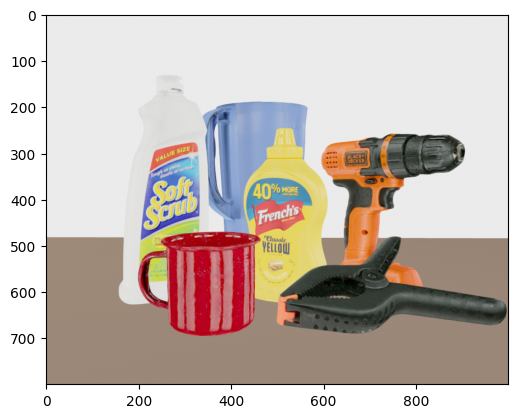

In [ ]:
dc = np.array([0,0,0.025])
img = render_rgb_view(
    meshlist,
    cam_centre=polar2cartesian(1.0, 30, 90),
    look_at=obj_centre+dc,
    fov=45,
    width_px=1000,
    height_px=800,
)
plt.imshow(img)

In [ ]:
import numpy as np
import open3d as o3d

def render_rgb_view(
    mesh: o3d.geometry.TriangleMesh,
    cam_centre=(0.3, 0.3, 0.0),
    look_at=(0.0, 0.0, 0.0),
    *,
    width_px: int = 360,
    height_px: int = 240,
    fov: float = 70.0,
    bg_rgba=(1.0, 1.0, 1.0, 1.0),  # white background
) -> np.ndarray:
    """Render an RGB image of `mesh` from a given camera pose."""
    renderer = o3d.visualization.rendering.OffscreenRenderer(width_px, height_px)

    # Simple material: unlit if vertex colors exist, otherwise lit shading
    mtl = o3d.visualization.rendering.MaterialRecord()
    mtl.shader = "defaultUnlit" if mesh.has_vertex_colors() else "defaultLit"
    renderer.scene.add_geometry("mesh", mesh, mtl)
    renderer.scene.set_background(bg_rgba)

    # Camera: vertical FOV in degrees, look-at with Z-up
    aspect = width_px / height_px
    cam = renderer.scene.camera
    cam.set_projection(
        fov, aspect, 0.01, 1000.0,
        o3d.visualization.rendering.Camera.FovType.Vertical
    )
    cam.look_at(look_at, cam_centre, [0, 0, 1])

    # Render to image and return RGB
    img = renderer.render_to_image()
    rgb = np.asarray(img)
    if rgb.ndim == 3 and rgb.shape[2] == 4:  # drop alpha if present
        rgb = rgb[:, :, :3]
    return rgb
